<a href="https://colab.research.google.com/github/FRJackson/hw/blob/main/5242hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

训练集样本数: 60000
单张图片张量形状: torch.Size([1, 28, 28]), 标签: 5


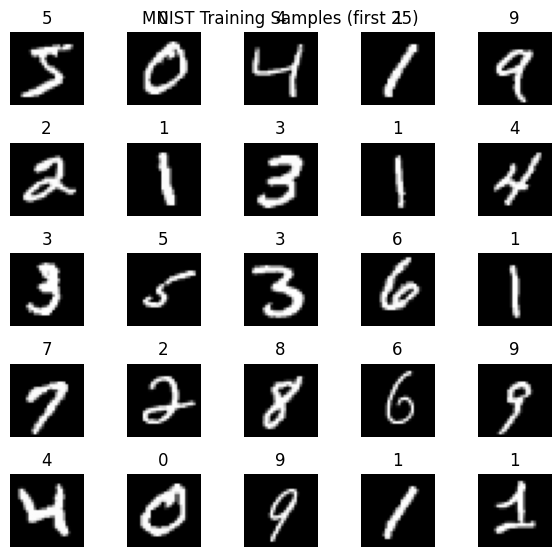

已准备前 10,000 张训练子集，大小: 10000


In [12]:
# ========== (a) 载入 MNIST 训练集并可视化若干样例 ==========
# 1) 基础库导入
import torch                         # PyTorch 主库
from torchvision import datasets     # torchvision 数据集接口
from torchvision import transforms   # 图像预处理/变换
import matplotlib.pyplot as plt      # 可视化绘图

# 2) 为了可重复性，设定随机种子（可选）
torch.manual_seed(42)                # 固定随机性，保证每次看到的顺序一致（部分操作会用到）

# 3) 指定数据下载/缓存目录
DATA_ROOT = "./data"                 # 本地保存 MNIST 的路径（Colab 会保存在 /content 下相对目录）

# 4) 定义数据变换：ToTensor() 把 PIL 图片转成 [0,1] 的张量，形状为 [1, 28, 28]
transform = transforms.ToTensor()    # (a) 只需转张量即可；(b) 的归一化/展平稍后再做

# 5) 加载 MNIST 训练集；若本地无数据则自动下载
mnist_train = datasets.MNIST(
    root=DATA_ROOT,                  # 数据根目录
    train=True,                      # 训练集（True=训练，False=测试）
    download=True,                   # 若无则下载
    transform=transform              # 使用上面定义的 ToTensor() 变换
)

# 6) 打印数据规模与首个样本的形状，做个快速自检
print(f"训练集样本数: {len(mnist_train)}")      # 通常为 60,000
x0, y0 = mnist_train[0]                         # 取第 0 个样本（x 是图像张量，y 是数字标签）
print(f"单张图片张量形状: {x0.shape}, 标签: {y0}")   # 形状应为 torch.Size([1, 28, 28])

# 7) 可视化前 25 张训练图片，5×5 网格排布
num_examples = 25                                # 要展示的样本数量
rows, cols = 5, 5                                # 网格行列
fig, axes = plt.subplots(rows, cols, figsize=(6, 6))  # 创建 5x5 的子图

for i, ax in enumerate(axes.flat):               # 遍历每个子图位置
    img, label = mnist_train[i]                  # 取第 i 张图片及其标签
    ax.imshow(img.squeeze(0), cmap="gray")       # squeeze 去掉通道维 (1,28,28)->(28,28)；灰度显示
    ax.set_title(str(label))                     # 子图标题显示该图片的数字标签
    ax.axis("off")                               # 隐藏坐标轴，图更清爽

plt.suptitle("MNIST Training Samples (first 25)", y=0.92)  # 整体标题（y 调整标题位置）
plt.tight_layout()
plt.show()

# ========== 可选：为后续小问准备“前 10,000 张”子集（现在不训练，只是准备好） ==========
from torch.utils.data import Subset               # 子集包装器

first_10k_indices = list(range(10_000))          # 索引 0..9999
mnist_train_10k = Subset(mnist_train, first_10k_indices)
print(f"已准备前 10,000 张训练子集，大小: {len(mnist_train_10k)}")


In [13]:
# (b) 将二维图像展平为 784 维，并确保特征在 [0,1]；基于(a)已加载的 mnist_train_10k
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# 若未执行(a)单元，自动补建前 10,000 张子集
try:
    mnist_train_10k
except NameError:
    DATA_ROOT = "./data"
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root=DATA_ROOT, train=True, download=True, transform=transform)
    mnist_train_10k = Subset(mnist_train, list(range(10_000)))

# 一次性取出前 10,000 张（X_img: [10000, 1, 28, 28]，数值已在[0,1]）
loader_10k = DataLoader(mnist_train_10k, batch_size=len(mnist_train_10k), shuffle=False)
X_img, y = next(iter(loader_10k))

# 展平到 [N, 784] 并保证连续内存；保存为后续通用变量名
X_train = X_img.view(X_img.size(0), -1).contiguous()
y_train = y

# 保险起见再夹紧到 [0,1]（ToTensor 本身已是[0,1]）
X_train = torch.clamp(X_train, 0.0, 1.0)

# 自检：应分别为 torch.Size([10000, 784]) 与 torch.Size([10000])
print("X_train:", X_train.shape, "y_train:", y_train.shape, "min/max:", X_train.min().item(), X_train.max().item())


X_train: torch.Size([10000, 784]) y_train: torch.Size([10000]) min/max: 0.0 1.0


In [14]:
# (c) 声明两层网络参数：输入784 → 隐藏128 → 输出10；权重与偏置均初始化为0.01
import torch

# 若已存在 X_train，则跟随其设备；否则自动选择 cuda/cpu
try:
    device = X_train.device
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_dim, hid_dim, out_dim = 784, 128, 10

W1 = torch.full((in_dim,  hid_dim), 0.01, dtype=torch.float32, device=device, requires_grad=True)
b1 = torch.full((hid_dim,),         0.01, dtype=torch.float32, device=device, requires_grad=True)
W2 = torch.full((hid_dim, out_dim), 0.01, dtype=torch.float32, device=device, requires_grad=True)
b2 = torch.full((out_dim,),         0.01, dtype=torch.float32, device=device, requires_grad=True)

params = [W1, b1, W2, b2]  # 便于后续统一遍历与更新

# 自检（可选）：打印形状与设备
print(f"W1:{W1.shape}, b1:{b1.shape}, W2:{W2.shape}, b2:{b2.shape}, device:{device}")


W1:torch.Size([784, 128]), b1:torch.Size([128]), W2:torch.Size([128, 10]), b2:torch.Size([10]), device:cpu


In [15]:
# (d) 定义前向函数：输入 X → 输出 Y（使用 ReLU 隐层；依赖已定义的 W1,b1,W2,b2）
import torch
import torch.nn.functional as F

# 若未运行(c)则尝试回退设备；建议按顺序执行(a)(b)(c)
try:
    _device = W1.device
except NameError:
    _device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 与(c)保持一致
in_dim, hid_dim, out_dim = 784, 128, 10

def forward(X: torch.Tensor) -> torch.Tensor:
    """
    X: [N, 784] 或 [N, 1, 28, 28]/[N, 28, 28]（自动展平）
    返回: 线性输出 Y，形状 [N, 10]
    """
    # 同步到与参数相同的设备/类型
    X = X.to(_device, dtype=torch.float32)

    # 若输入还是图像形状则展平到 [N, 784]
    if X.dim() == 4 and X.shape[2:] == (28, 28):
        X = X.view(X.size(0), -1)
    elif X.dim() == 3 and X.shape[1:] == (28, 28):
        X = X.view(X.size(0), -1)

    # 形状校验
    assert X.dim() == 2 and X.size(1) == in_dim, f"Expected [N,{in_dim}], got {tuple(X.shape)}"

    # 前向：h1 = ReLU(XW1 + b1), Y = h1W2 + b2
    h1 = F.relu(X @ W1 + b1)   # [N, 128]
    Y  = h1 @ W2 + b2          # [N, 10]
    return Y

# 自检（可选）：应输出 [64, 10]
try:
    _Y = forward(X_train[:64])
    print("forward() OK; sample output shape:", _Y.shape)
except Exception as e:
    print("forward() error:", e)


forward() OK; sample output shape: torch.Size([64, 10])


In [16]:
# (e) 训练循环：GD（手动更新），1000 步；CrossEntropyLoss；每 100 步打印一次损失
import torch

# 准备设备与数据/参数
device = W1.device                                  # 与参数一致的设备
X = X_train.to(device, dtype=torch.float32)         # [10000, 784] 输入
y = y_train.to(device, dtype=torch.long)            # [10000] 真实标签(类别索引)

# 损失函数：多分类交叉熵（输入为 logits，标签为类别索引）
criterion = torch.nn.CrossEntropyLoss()

# 超参数
lr = 1e-3                                           # 学习率
num_steps = 1000                                     # 训练步数

# 记录每一步损失以便后续(f)画图
loss_history_gd_const = []

# 训练循环
for step in range(1, num_steps + 1):
    # 1) 梯度清零（上一步的梯度不能残留）：将 grad 置 None 更高效
    for p in (W1, b1, W2, b2):
        p.grad = None

    # 2) 前向计算：得到 logits（未经过 softmax 的得分）
    logits = forward(X)                              # [N, 10]

    # 3) 计算损失
    loss = criterion(logits, y)                      # 标量损失

    # 4) 反向传播：自动计算各参数的梯度
    loss.backward()

    # 5) 参数更新（手动 GD）：param -= lr * grad
    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad

    # 6) 记录与打印
    loss_val = loss.item()
    loss_history_gd_const.append(loss_val)
    if step % 100 == 0:
        print(f"[GD-const-init] step {step:4d}/{num_steps} | loss = {loss_val:.4f}")


[GD-const-init] step  100/1000 | loss = 2.2891
[GD-const-init] step  200/1000 | loss = 2.2881
[GD-const-init] step  300/1000 | loss = 2.2876
[GD-const-init] step  400/1000 | loss = 2.2873
[GD-const-init] step  500/1000 | loss = 2.2869
[GD-const-init] step  600/1000 | loss = 2.2865
[GD-const-init] step  700/1000 | loss = 2.2862
[GD-const-init] step  800/1000 | loss = 2.2858
[GD-const-init] step  900/1000 | loss = 2.2854
[GD-const-init] step 1000/1000 | loss = 2.2850


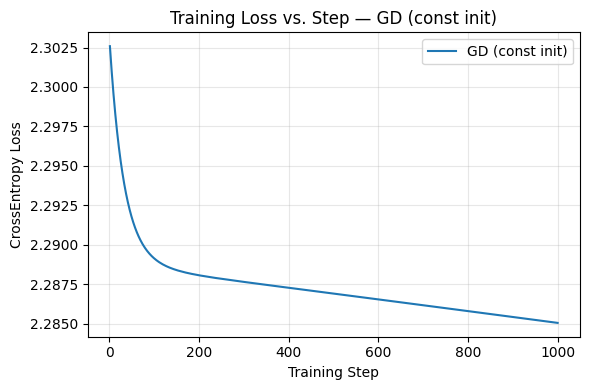

In [17]:
# (f) 绘制训练损失曲线（基于 e 中的 loss_history_gd_const）
import matplotlib.pyplot as plt
import numpy as np

history = loss_history_gd_const
steps = np.arange(1, len(history) + 1)

plt.figure(figsize=(6, 4))
plt.plot(steps, history, label='GD (const init)')
plt.xlabel('Training Step')
plt.ylabel('CrossEntropy Loss')
plt.title('Training Loss vs. Step — GD (const init)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
# (g) 以正态分布初始化权重（均值0、标准差0.1），其余设置与(e)相同；对比收敛速度
import torch
import torch.nn.functional as F

# 设备与数据
try:
    device = X_train.device
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = X_train.to(device, dtype=torch.float32)
y = y_train.to(device, dtype=torch.long)

# 结构
in_dim, hid_dim, out_dim = 784, 128, 10

# 随机种子（可复现）
torch.manual_seed(42)

# 权重~N(0,0.1)，偏置保持常数0.01
W1_r = torch.randn(in_dim,  hid_dim, device=device, dtype=torch.float32) * 0.1
b1_r = torch.full((hid_dim,),         0.01, device=device, dtype=torch.float32)
W2_r = torch.randn(hid_dim, out_dim, device=device, dtype=torch.float32) * 0.1
b2_r = torch.full((out_dim,),         0.01, device=device, dtype=torch.float32)

# 需参与反传
for p in (W1_r, b1_r, W2_r, b2_r):
    p.requires_grad_(True)

def forward_rand(X):
    if X.dim() == 4 and X.shape[2:] == (28, 28):
        X = X.view(X.size(0), -1)
    elif X.dim() == 3 and X.shape[1:] == (28, 28):
        X = X.view(X.size(0), -1)
    h1 = F.relu(X @ W1_r + b1_r)
    Y  = h1 @ W2_r + b2_r
    return Y

# 训练设置
criterion = torch.nn.CrossEntropyLoss()
lr = 1e-3
num_steps = 1000
loss_history_gd_rand = []

# 训练循环（GD，手动更新）
for step in range(1, num_steps + 1):
    for p in (W1_r, b1_r, W2_r, b2_r):
        p.grad = None

    logits = forward_rand(X)
    loss = criterion(logits, y)
    loss.backward()

    with torch.no_grad():
        W1_r -= lr * W1_r.grad
        b1_r -= lr * b1_r.grad
        W2_r -= lr * W2_r.grad
        b2_r -= lr * b2_r.grad

    loss_history_gd_rand.append(loss.item())
    if step % 100 == 0:
        print(f"[GD-rand-init] step {step:4d}/{num_steps} | loss = {loss.item():.4f}")


[GD-rand-init] step  100/1000 | loss = 2.3556
[GD-rand-init] step  200/1000 | loss = 2.2358
[GD-rand-init] step  300/1000 | loss = 2.1383
[GD-rand-init] step  400/1000 | loss = 2.0534
[GD-rand-init] step  500/1000 | loss = 1.9766
[GD-rand-init] step  600/1000 | loss = 1.9053
[GD-rand-init] step  700/1000 | loss = 1.8383
[GD-rand-init] step  800/1000 | loss = 1.7747
[GD-rand-init] step  900/1000 | loss = 1.7142
[GD-rand-init] step 1000/1000 | loss = 1.6564


In [19]:
# (h) 使用(g)中更优的初始化方式 + Adam(lr=1e-3) 训练第三个同结构网络
import torch
import torch.nn.functional as F

# 数据与设备（回退兼容）
try:
    device = X_train.device
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    from torchvision import datasets, transforms
    from torch.utils.data import Subset, DataLoader
    DATA_ROOT = "./data"
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root=DATA_ROOT, train=True, download=True, transform=transform)
    mnist_train_10k = Subset(mnist_train, list(range(10_000)))
    loader_10k = DataLoader(mnist_train_10k, batch_size=len(mnist_train_10k), shuffle=False)
    X_img, y = next(iter(loader_10k))
    X_train = X_img.view(X_img.size(0), -1).contiguous()
    y_train = y

X = X_train.to(device, dtype=torch.float32)
y = y_train.to(device, dtype=torch.long)

in_dim, hid_dim, out_dim = 784, 128, 10

# 自动根据(g)与(e)的最终损失选择“更优初始化”；若不可用则默认选择随机正态初始化
use_rand = True
try:
    if ('loss_history_gd_const' in globals()) and ('loss_history_gd_rand' in globals()):
        if len(loss_history_gd_const) > 0 and len(loss_history_gd_rand) > 0:
            use_rand = (loss_history_gd_rand[-1] <= loss_history_gd_const[-1])
    elif 'loss_history_gd_const' in globals() and len(loss_history_gd_const) > 0:
        use_rand = False
except Exception:
    use_rand = True

torch.manual_seed(42)

if use_rand:
    # 权重 ~ N(0, 0.1)，偏置常数 0.01（与(g)一致）
    W1_a = (torch.randn(in_dim,  hid_dim, device=device, dtype=torch.float32) * 0.1).requires_grad_()
    b1_a = torch.full((hid_dim,), 0.01, device=device, dtype=torch.float32).requires_grad_()
    W2_a = (torch.randn(hid_dim, out_dim, device=device, dtype=torch.float32) * 0.1).requires_grad_()
    b2_a = torch.full((out_dim,), 0.01, device=device, dtype=torch.float32).requires_grad_()
    init_used = "rand_normal(0,0.1)"
else:
    # 常数 0.01 初始化（与(e)一致）
    W1_a = torch.full((in_dim,  hid_dim), 0.01, device=device, dtype=torch.float32).requires_grad_()
    b1_a = torch.full((hid_dim,),       0.01, device=device, dtype=torch.float32).requires_grad_()
    W2_a = torch.full((hid_dim, out_dim), 0.01, device=device, dtype=torch.float32).requires_grad_()
    b2_a = torch.full((out_dim,),       0.01, device=device, dtype=torch.float32).requires_grad_()
    init_used = "constant(0.01)"

def forward_adam(X: torch.Tensor) -> torch.Tensor:
    if X.dim() == 4 and X.shape[2:] == (28, 28):
        X = X.view(X.size(0), -1)
    elif X.dim() == 3 and X.shape[1:] == (28, 28):
        X = X.view(X.size(0), -1)
    h1 = F.relu(X @ W1_a + b1_a)
    Y  = h1 @ W2_a + b2_a
    return Y

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([W1_a, b1_a, W2_a, b2_a], lr=1e-3)
num_steps = 1000

loss_history_adam = []

print(f"[Adam] init used: {init_used}")
for step in range(1, num_steps + 1):
    optimizer.zero_grad(set_to_none=True)
    logits = forward_adam(X)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()

    loss_history_adam.append(loss.item())
    if step % 100 == 0:
        print(f"[Adam-{init_used}] step {step:4d}/{num_steps} | loss = {loss.item():.4f}")


[Adam] init used: rand_normal(0,0.1)
[Adam-rand_normal(0,0.1)] step  100/1000 | loss = 0.2310
[Adam-rand_normal(0,0.1)] step  200/1000 | loss = 0.1131
[Adam-rand_normal(0,0.1)] step  300/1000 | loss = 0.0607
[Adam-rand_normal(0,0.1)] step  400/1000 | loss = 0.0339
[Adam-rand_normal(0,0.1)] step  500/1000 | loss = 0.0199
[Adam-rand_normal(0,0.1)] step  600/1000 | loss = 0.0124
[Adam-rand_normal(0,0.1)] step  700/1000 | loss = 0.0083
[Adam-rand_normal(0,0.1)] step  800/1000 | loss = 0.0059
[Adam-rand_normal(0,0.1)] step  900/1000 | loss = 0.0044
[Adam-rand_normal(0,0.1)] step 1000/1000 | loss = 0.0034


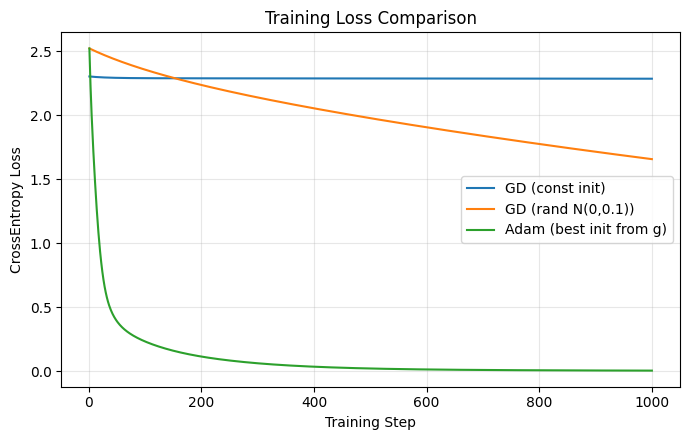

In [20]:
# (i) 将三次训练的损失曲线绘制在同一张图中
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 4.5))

plotted = False

if 'loss_history_gd_const' in globals() and len(loss_history_gd_const) > 0:
    steps_const = np.arange(1, len(loss_history_gd_const) + 1)
    plt.plot(steps_const, loss_history_gd_const, label='GD (const init)')
    plotted = True

if 'loss_history_gd_rand' in globals() and len(loss_history_gd_rand) > 0:
    steps_rand = np.arange(1, len(loss_history_gd_rand) + 1)
    plt.plot(steps_rand, loss_history_gd_rand, label='GD (rand N(0,0.1))')
    plotted = True

if 'loss_history_adam' in globals() and len(loss_history_adam) > 0:
    steps_adam = np.arange(1, len(loss_history_adam) + 1)
    plt.plot(steps_adam, loss_history_adam, label='Adam (best init from g)')
    plotted = True

if not plotted:
    print("No histories found. Please run parts (e), (g), and (h) first.")
else:
    plt.xlabel('Training Step')
    plt.ylabel('CrossEntropy Loss')
    plt.title('Training Loss Comparison')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
